# Instrument recognition in musical audio signals
Group 2: Jakob Dittrich, Lea Franz, David Reiter, Thomas Sickinger

## Setup

In [813]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from os import listdir
import librosa.display

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# color for plots
pltcolor = '#002b36'
plt.rcParams['figure.figsize'] = [16, 9]

In [814]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

## Data

The training data contains 6705 audio files in 16 bit stereo wav format sampled at 44.1kHz. They are excerpts of 3 seconds from more than 2000 distinct recordings. The number of files per instrument are: cello (388), clarinet (505), flute (451), acoustic guitar (637), electric guitar (760), organ (682), piano (721), saxophone (626), trumpet (577), violin (580), human voice (778).


The test data contains 2874 excerpts in 16 bit stereo wav format sampled at 44.1kHz.

Source: https://www.upf.edu/web/mtg/irmas

### Loading the data
For loading the audio data we use **librosa**. This is python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.

## Analysis of data

### Instrument class balance

The plot shows that the classes are not balanced. The class with the most samples is **vio** and the class with the least samples is **cel**.

In [815]:
class_dirs = os.listdir('./IRMAS-TrainingData/')
class_dirs.remove('.DS_Store')
class_dirs.remove('README.txt')
class_dirs

['pia', 'voi', 'tru', 'sax', 'org', 'cla', 'gac', 'vio', 'flu', 'gel', 'cel']

This project uses the following instruments: 

In [816]:
Instruments = ['flu', 'pia', 'tru', 'org', 'gac', 'voi']
Instruments

['flu', 'pia', 'tru', 'org', 'gac', 'voi']

The plot shows that the the numbers of samples per instrument are not balanced. The instrument with the most samples is **voi** and the instrument with the least samples is **flu**.

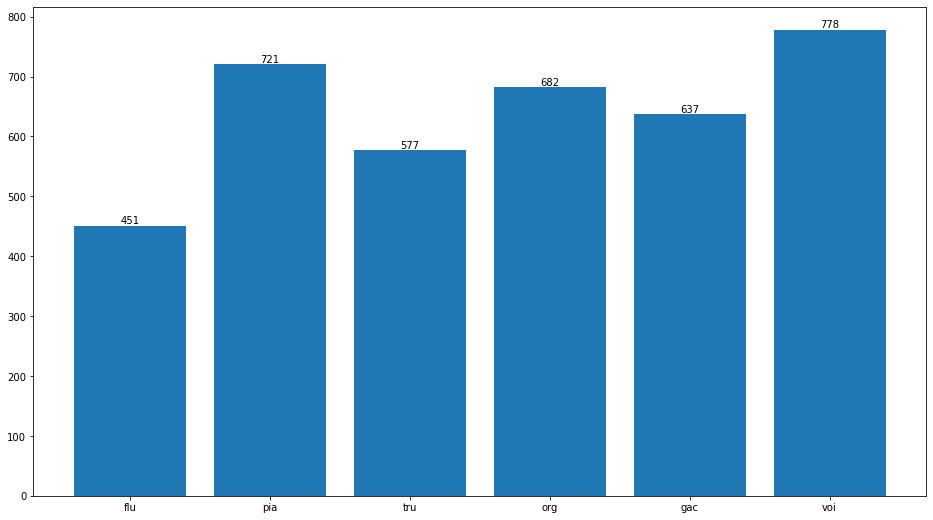

In [817]:
number_of_files = []
for class_name in Instruments:
    class_dir = os.listdir('./IRMAS-TrainingData/'+class_name)
    number_of_files.append(len(class_dir))

fig, ax = plt.subplots()
bars = ax.bar(Instruments, number_of_files);
ax.bar_label(bars);

### Example file

In [818]:
y , sr = librosa.load('./IRMAS-TrainingData/cel/008__[cel][nod][cla]0058__1.wav')

**Waveform in the time domain**

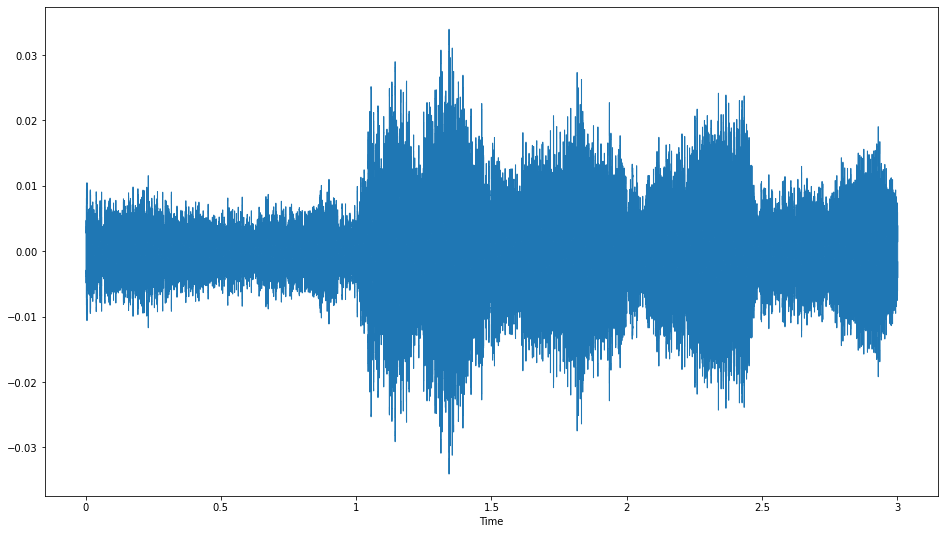

In [819]:
librosa.display.waveshow(y, sr=sr);

**Spectrogram**

A spectrogram is the visual representation of the spectrum of frequencies of a signal over time.

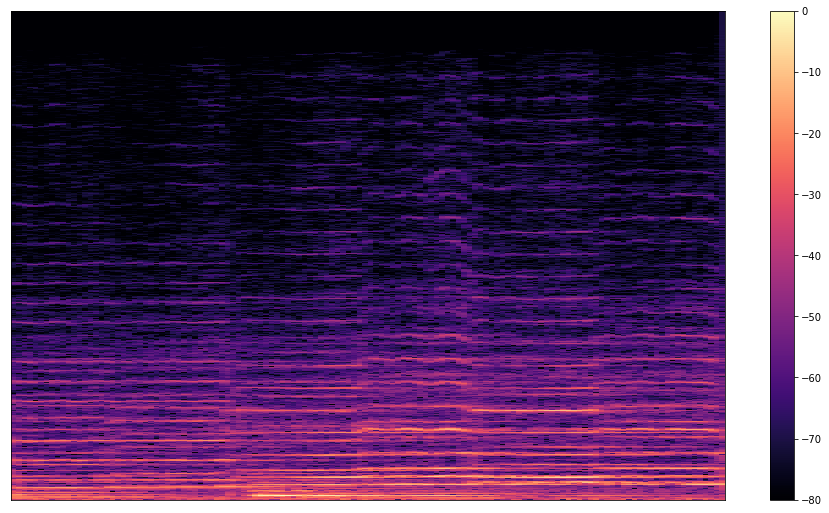

In [820]:
stft = librosa.stft(y)  # short time fourier transform
magnitudes_to_decibel = librosa.amplitude_to_db(np.abs(stft), ref=np.max) # mapping magnitudes to decibel scale

plt.figure()
librosa.display.specshow(magnitudes_to_decibel)
plt.colorbar();

## Feature extraction

**Zero Crossing Rate:** the rate at which the signal crosses zero

**Spectral Centroid:** the center of mass in the spectrum

**Spectral Bandwidth:** the weighted average of the frequency signal by its spectrum

**Spectral Roll-Off:** frequency below which a specified percentage of the total spectral energy

In [821]:
header = 'filename rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21): # TODO why 21?
    header += f' mfcc{i}'
header += ' label'
header = header.split()

Creating a .csv file for storing the data from the music files as extracted features

In [822]:


file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)



In [823]:
for i in Instruments:
    for filename in os.listdir(f'./IRMAS-TrainingData/{i}'):
        songname = f'./IRMAS-TrainingData/{i}/{filename}'
        y, sr = librosa.load(songname, sr =44100)
        rms = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {i}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [824]:
df = pd.read_csv('data.csv')
df.head()


,filename,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,[flu][cla]0441__1.wav,0.149752,2097.888100,2489.946539,3917.463313,0.044588,-183.342606,150.484253,-45.797676,31.572205,...,12.865310,5.979919,-0.760616,-2.864177,-10.078252,-9.153670,-5.919430,1.270639,-5.099973,flu
1,[flu][pop_roc]0372__1.wav,0.070092,1788.342988,3053.350600,3598.705395,0.024457,-266.117035,168.074844,8.713345,38.584534,...,0.733319,-3.077334,-3.865695,-7.703886,-7.980325,-0.265409,-0.590245,2.773574,-1.158271,flu
2,[flu][pop_roc]0489__3.wav,0.075266,1415.090142,1338.522972,2574.007601,0.044043,-260.943909,235.551620,-72.608337,1.650668,...,-4.480639,-4.898223,1.072633,8.016642,8.928833,3.030757,-6.311553,-13.654664,-10.805024,flu
3,061__[flu][dru][pop_roc]0419__2.wav,0.157308,1457.059727,2070.808324,2434.665329,0.035720,-223.190750,188.077667,-17.081150,22.657726,...,11.541116,8.014239,-9.074386,-9.779533,-8.943732,-7.005507,-2.292251,-2.062893,1.445741,flu
4,[flu][cla]0373__1.wav,0.048835,1903.336677,2381.898288,2342.879012,0.047959,-469.845367,92.393463,-23.503504,-9.021847,...,-23.929066,-29.581629,-23.973606,11.314720,24.038225,16.351347,-0.176796,-3.863951,-2.982664,flu


## Analysis of features

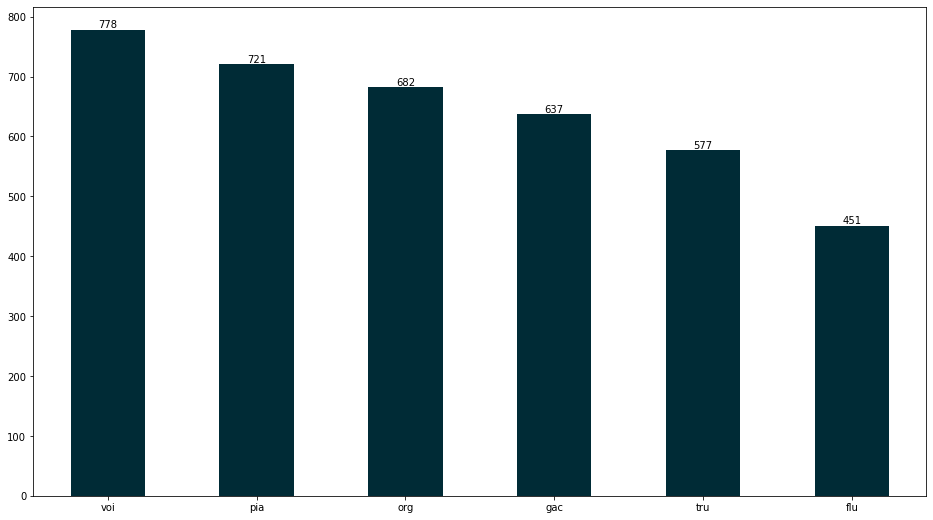

In [825]:
table = df['label'].value_counts()
ax = table.plot(kind='bar', rot=0, color=pltcolor);
ax.bar_label(ax.containers[0]);

The class imbalance and the number of samples per instrument are still the same after the feature extraction.

### Correlation between features

The most correlated features are spectral_centroid and rollof, spectral bandwith and rollof as well as  mfcc2 and spectral_centroid (inverse).

In [826]:
df_corr = df
df_corr.corr().unstack().sort_values().drop_duplicates()

mfcc2               spectral_centroid    -0.813673
                    spectral_bandwidth   -0.808919
rolloff             mfcc2                -0.756098
mfcc6               mfcc2                -0.625813
mfcc2               mfcc4                -0.616627
                                            ...   
spectral_centroid   zero_crossing_rate    0.844379
                    spectral_bandwidth    0.895599
spectral_bandwidth  rolloff               0.923575
rolloff             spectral_centroid     0.966131
rms                 rms                   1.000000
Length: 301, dtype: float64

Highest correlation of 0.967746 between spectral_centroid and rolloff

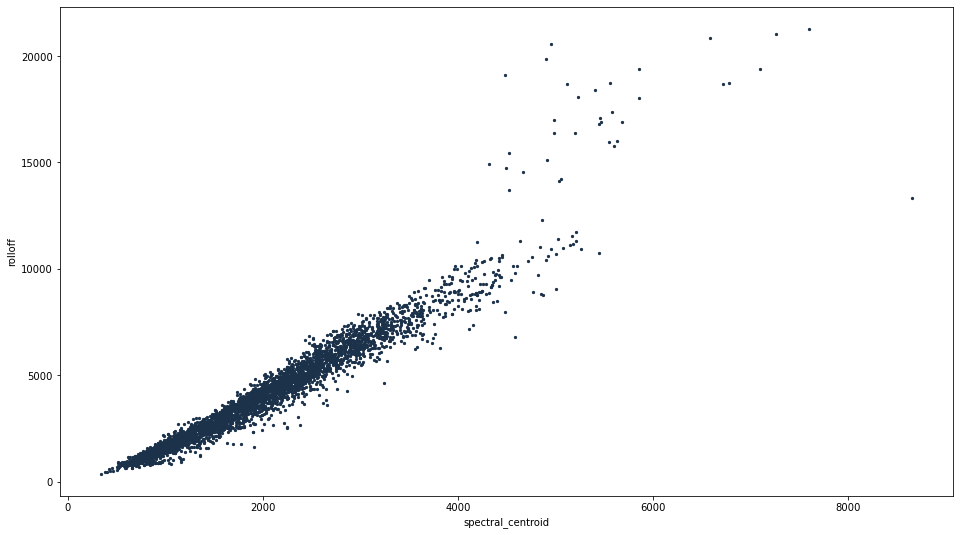

In [827]:
df.plot.scatter("spectral_centroid", "rolloff", c="#1b324a", marker='.');

## Preprocessing

### NaN values

In [828]:
df.isnull().values.any()

False

There are no NaN values in this dataset.

### Outliers

In [829]:
cols = df.columns.tolist()
cols.remove('label')
cols.remove('filename')

for col in cols:
    q_low = df[col].quantile(0.01)
    q_hi  = df[col].quantile(0.99)
    df_filtered = df[(df[col] < q_hi) & (df[col] > q_low)]

print(str(len(df)-len(df_filtered))+' rows with outliers removed.')
df = df_filtered


78 rows with outliers removed.


### Scaling

In [830]:
# drop filename from dataframe
df = df.drop(['filename'],axis=1)

In [831]:
# extract instrument labels
instru_list = df.iloc[:, -1]
encoder = LabelEncoder()

# encode labels to numeric values
y = encoder.fit_transform(instru_list)

df['label'] = y

# uniformly scale data
scaler = StandardScaler()
X_transform = scaler.fit_transform(df.iloc[:, :-1].values)

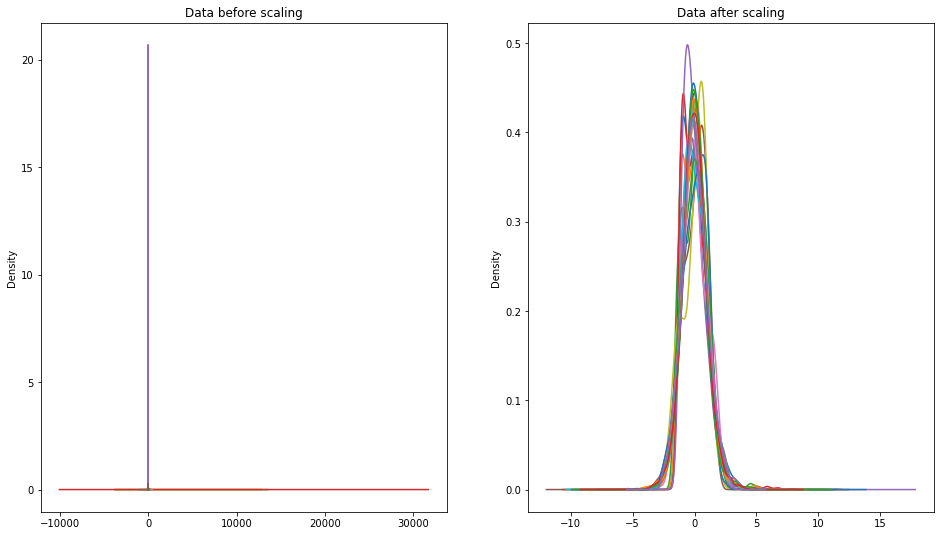

In [832]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title("Data before scaling")
ax2.set_title("Data after scaling")

df.plot.density(ax=ax1, legend=False);
df_scaled = pd.DataFrame(X_transform, columns=df.iloc[:, :-1].columns)
df_scaled.plot.density(ax=ax2, legend=False);

In [833]:
# print labels
print('Numberic values instead of class names: ')
print(y)

Numberic values instead of class names: 
[0 0 0 ... 5 5 5]


### Features

The main feature extraction was already done by extracting the features from the .wav files.

#### Feature reduction with PCA

In [834]:
features = df # renaming

In [835]:
pca = PCA(n_components=20).fit_transform(X_transform) # test components

This is how the data looks as 2 principal components, however a reduction from 25 to 2 is too much.   
Therefore 20 components are chosen.

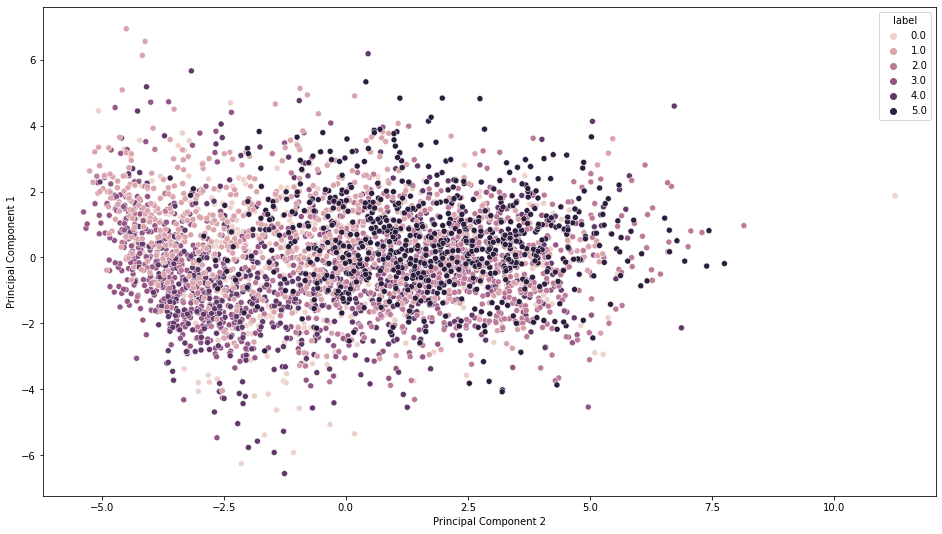

In [836]:
pca = PCA(n_components=2).fit_transform(X_transform) # test components
df_pca2 = pd.DataFrame(data = pca, columns = ['pca1', 'pca2'])
sns.scatterplot(df_pca2.pca1, df_pca2.pca2, hue = df.label)
plt.ylabel('Principal Component 1')
plt.xlabel('Principal Component 2')
plt.show()

## Models

In [837]:
# shuffle dataframe
df1 = shuffle(df)
df1.head()

,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
21,0.165744,1769.983485,2393.335159,3524.295291,0.036472,-186.297089,177.786728,-6.788514,40.113503,-10.536499,...,4.600759,2.480183,-1.177333,-1.222682,-4.679367,-3.376363,-7.755116,-4.575410,-8.993884,0
3557,0.269309,2292.931649,2680.367440,4270.973659,0.058343,-64.983200,174.692352,-64.706665,43.915222,-18.077494,...,1.323154,1.487632,-0.973501,9.125792,0.616041,2.431580,-13.362320,-6.124382,-11.420570,5
3642,0.120508,2476.824816,3178.166200,5229.741607,0.047531,-149.572418,162.806625,-31.445074,42.712402,-18.723455,...,6.439054,-1.851544,4.264477,2.926266,-0.939635,-0.222071,-6.929781,2.343176,-9.397927,5
3092,0.037864,2480.438554,2931.264343,4948.396590,0.055555,-272.180420,151.720505,-38.116108,54.993038,-0.209364,...,-0.452755,-4.267831,-2.808711,-3.752560,-4.231733,-2.222930,-1.535630,-5.865283,-7.365989,5
1883,0.185722,2527.077743,3217.777831,5141.696579,0.060909,-105.777267,154.189194,-36.819557,23.494280,-5.827456,...,7.908416,-0.970299,-4.809776,-5.039132,1.665869,0.833375,2.884858,1.169193,-2.877379,2


Test data with all features

In [838]:
# split dataset in train and test data
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, test_size=0.2)

Test data with PCA

In [839]:
# split dataset in train and test data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca, y, test_size=0.2)

### SVM Model

#### SVM with all features

In [840]:
# create SVM kernel
svclassifier = SVC(kernel='rbf', C = 10.0, gamma=0.1)

# fit data
svclassifier.fit(X_train, y_train);

In [841]:
# Calculate the accuracy score and predict target values
score = svclassifier.score(X_train, y_train)
print("Test score: {0:.2f} %".format(100 * score))

Test score: 99.97 %


Recall:  [0.63513514 0.70866142 0.78225806 0.72789116 0.71794872 0.86060606]
Precision:  [0.53409091 0.73770492 0.76984127 0.77536232 0.80769231 0.80681818]
F1-Score:  [0.58024691 0.72289157 0.776      0.75087719 0.760181   0.83284457]
Accuracy: 0.75  , 567
Number of samples: 754


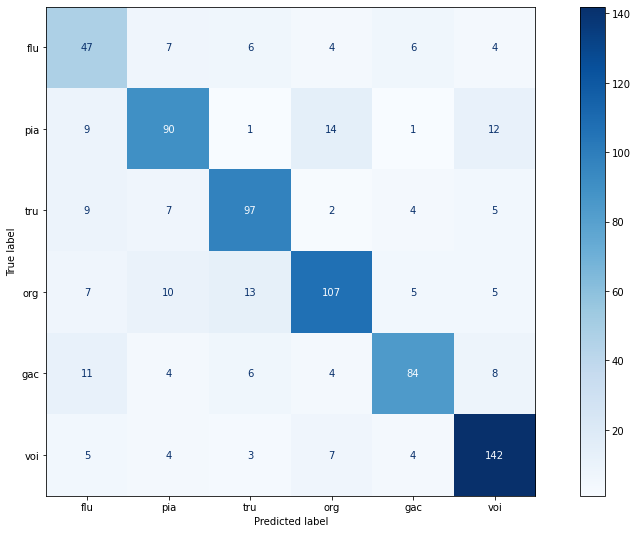

In [842]:
predicted_labels = svclassifier.predict(X_test)

print("Recall: ", recall_score(y_test, predicted_labels,average=None))
print("Precision: ", precision_score(y_test, predicted_labels,average=None))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )

print("Number of samples:",y_test.shape[0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels), display_labels=Instruments).plot(cmap="Blues");


#### SVM with PCA

In [843]:
# create SVM kernel
svclassifier = SVC(kernel='rbf', C = 10.0, gamma=0.1)

# fit data
svclassifier.fit(X_train_pca, y_train_pca);

In [844]:
# Calculate the accuracy score and predict target values
score = svclassifier.score(X_train_pca, y_train_pca)
print("Test score: {0:.2f} %".format(100 * score))

Test score: 40.51 %


Recall:  [0.         0.39230769 0.53191489 0.51282051 0.17924528 0.56115108]
Precision:  [0.         0.45945946 0.36407767 0.58394161 0.30645161 0.32773109]
F1-Score:  [0.         0.42323651 0.43227666 0.54607509 0.22619048 0.4137931 ]
Accuracy: 0.40  , 303
Number of samples: 754


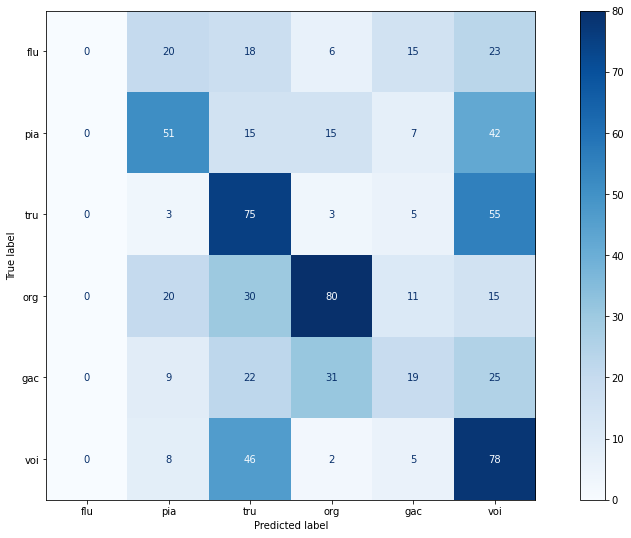

In [845]:
predicted_labels = svclassifier.predict(X_test_pca)

print("Recall: ", recall_score(y_test_pca, predicted_labels,average=None))
print("Precision: ", precision_score(y_test_pca, predicted_labels,average=None))
print("F1-Score: ", f1_score(y_test_pca, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(y_test_pca, predicted_labels,normalize=True), accuracy_score(y_test_pca, predicted_labels,normalize=False) )

print("Number of samples:",y_test_pca.shape[0])
ConfusionMatrixDisplay(confusion_matrix(y_test_pca, predicted_labels), display_labels=Instruments).plot(cmap="Blues");


### Logistic Regression

#### Logistic Regression with all features

In [846]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [847]:
print('Best parameters: '+str(logreg_cv.best_params_))
print('Best accuracy score: '+str(logreg_cv.best_score_))

Best parameters: {'C': 1000.0, 'penalty': 'l2'}
Best accuracy score: 0.581313942487514


Logistic regression with best params

In [848]:
logreg_best = LogisticRegression(C=10.0, penalty='l2')
logreg_best.fit(X_train, y_train);
score = logreg_best.score(X_train, y_train)
print("Test score: {0:.2f} %".format(100 * score))

Test score: 60.19 %


Recall:  [0.35135135 0.62992126 0.58870968 0.6462585  0.52136752 0.67272727]
Precision:  [0.56521739 0.62015504 0.51408451 0.63758389 0.61616162 0.58730159]
F1-Score:  [0.43333333 0.625      0.54887218 0.64189189 0.56481481 0.62711864]
Accuracy: 0.59  , 446
Number of samples: 754


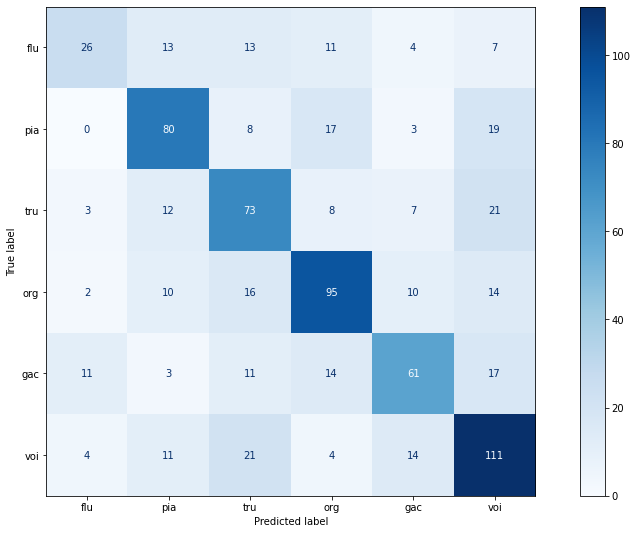

In [849]:
predicted_labels = logreg_best.predict(X_test)

print("Recall: ", recall_score(y_test, predicted_labels,average=None))
print("Precision: ", precision_score(y_test, predicted_labels,average=None))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )

print("Number of samples:",y_test.shape[0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels), display_labels=Instruments).plot(cmap="Blues");

#### Logistic Regression with PCA

In [850]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train_pca,y_train_pca);

In [851]:
print('Best parameters: '+str(logreg_cv.best_params_))
print('Best accuracy score: '+str(logreg_cv.best_score_))

Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best accuracy score: 0.3788970539702097


Logistic regression with best params

In [852]:
logreg_best = LogisticRegression(C=0.1, penalty='l2')
logreg_best.fit(X_train_pca, y_train_pca);
score = logreg_best.score(X_train_pca, y_train_pca)
print("Test score: {0:.2f} %".format(100 * score))

Test score: 38.06 %


Recall:  [0.         0.41538462 0.36879433 0.56410256 0.08490566 0.54676259]
Precision:  [0.         0.48214286 0.33766234 0.42512077 0.16981132 0.33333333]
F1-Score:  [0.         0.44628099 0.35254237 0.48484848 0.11320755 0.41416894]
Accuracy: 0.37  , 279
Number of samples: 754


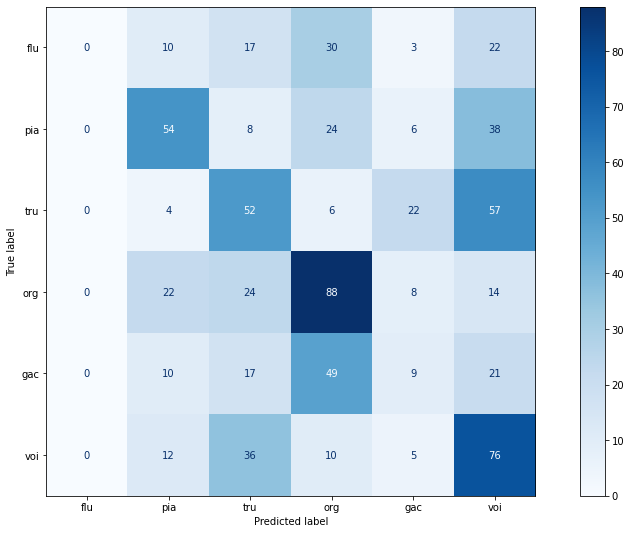

In [853]:
predicted_labels = logreg_best.predict(X_test_pca)

print("Recall: ", recall_score(y_test_pca, predicted_labels,average=None))
print("Precision: ", precision_score(y_test_pca, predicted_labels,average=None))
print("F1-Score: ", f1_score(y_test_pca, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(y_test_pca, predicted_labels,normalize=True), accuracy_score(y_test_pca, predicted_labels,normalize=False) )

print("Number of samples:",y_test_pca.shape[0])
ConfusionMatrixDisplay(confusion_matrix(y_test_pca, predicted_labels), display_labels=Instruments).plot(cmap="Blues");


## Conclusion

which instrument the best

explanation which model